# Training High Energy Physics Generative Models using Simulated Data
Kyle Cranmer and Lukas Heinrich, New York University

In High Energy Physics (HEP) it's common to generate samples of simulated particle collisions using generators that incorporate multiple computational stages, from field-theoretic Feynman diagram calculation to the simulation of the interaction of particles with the measurement apparatus. The underlying parameters of these models are the free parameters of the underlying theory of particle interactions (particle masses, interaction strengths, etc.).

This notebook encapsulates a simplified workflow generating using the MadGraph package[1]. In particular collisions of electrons and positrons resulting in muon-antimuon pairs are simulated. The main event features are the energies and cartesian momentum components of the final state muons (labelled E, px, py, pz). In the analysis below, event features are generated for a number of different beam energies. 

Generators such as these could be used to study the training of generative models based on such simulated datasets. The derived models may ultimately be able to rediscover the hidden parameters (i.e. the physics theory) based on which the data was produced.


[1] J. Alwall, et al. arXiv:1405.0301 [hep-ph]

## Preparation

First some basic imports, we will use the [yadage](https://github.com/diana-hep/yadage.git) workflow engine to steer the generation of the particle collisions using the generator MadGraph. To monitor the progress, we also import the yadage widget.

In [1]:
%%javascript
require.config({paths: {
        vis: "http://cdnjs.cloudflare.com/ajax/libs/vis/4.17.0/vis",
        yadage: "https://rawgit.com/lukasheinrich/yadage-ipython/master/yadagealpha"
    }
});

<IPython.core.display.Javascript object>

In [2]:
import yadage_widget
import adage
import adage.backends
import psutil
from hepworkflow import setup_workflow

In [3]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [4]:
import ipywidgets

We prepare four runs at different beam energies. A beam energy of 45 GeV is particularly interesting as this will resonantly produce the Z-boson. We choose a range around this special value.

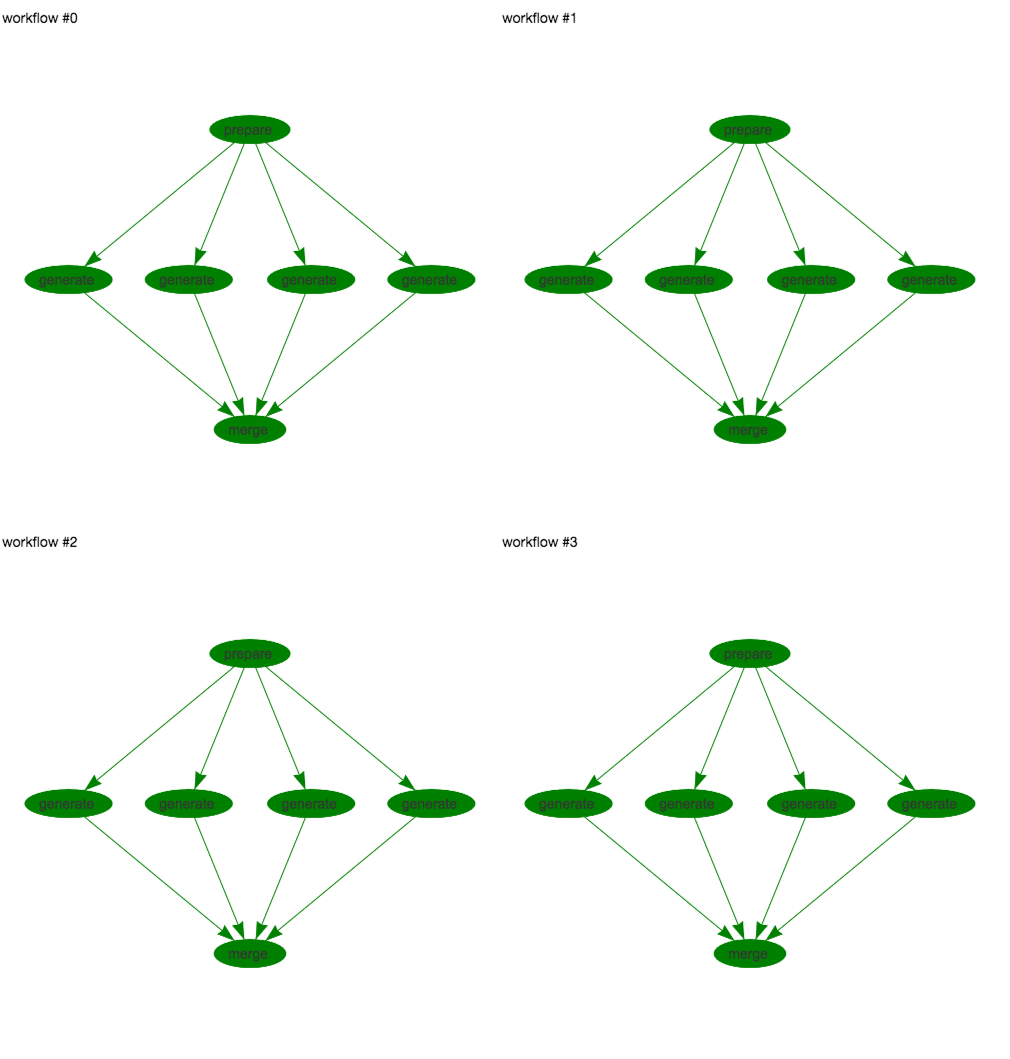

In [73]:
energies = np.linspace(40,50,4)

workflows = []
widgets = []
for index,energy in enumerate(energies):
    workdir = 'workdir_{}'.format(index)
    workflow = setup_workflow(workdir = workdir, nevents = 4000, beamenergy = energy)
    widget = yadage_widget.WorkflowWidget(workflow)
    widget.width = 100
    workflows.append(workflow)
    widgets.append(widget)


    
wflowgrid = np.array([ipywidgets.VBox([ipywidgets.Label('workflow #{}'.format(i)),w]) for i,w in enumerate(widgets)]).reshape(2,2)
ipywidgets.VBox([ipywidgets.HBox(list(row)) for row in wflowgrid])

Executing the next cell will launch the generation of the simulated datasets. Watch the graphs above to monitor the progress

In [74]:
backend = adage.backends.MultiProcBackend(psutil.cpu_count())
for i,widget in enumerate(widgets):
    adage.rundag(widget.wflow,
                 update_interval = 3,
                 default_trackers = False,
                 additional_trackers=[widget.adagetracker],
                 backend = backend)

With the simulated datasets, we will project the higher-dimensional feature vectors (momenta of the particles) to a single event-observable, namely the cosine of the angle between the incoming electron and the outgoing muon.

In [77]:
import jsonlines
def analysis(workdir):
    inputfile = '{}/merged.jsonl'.format(workdir)
    costhetas = []
    for i,e in enumerate(jsonlines.Reader(open(inputfile))):
        els = [p for p in e['particles'] if p['id'] == 11]
        mus = [p for p in e['particles'] if p['id'] == 13]
        assert len(mus) == 1
        assert len(els) == 1
        mu = mus[0]
        el = els[0]
        el_px, el_py, el_pz = [el[x] for x in ['px','py','pz']]
        mu_px, mu_py, mu_pz = [mu[x] for x in ['px','py','pz']]
        costheta = mu_pz/el_pz
        costhetas.append(costheta)
    return costhetas

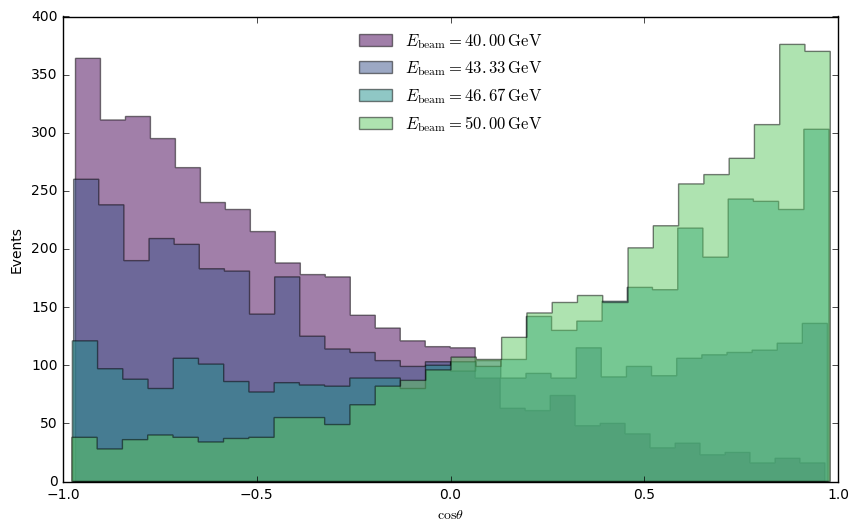

In [79]:
labels = []
plt.figure(figsize=(10, 6))
for index,energy in enumerate(energies):
    _,_,_ = plt.hist(analysis('workdir_{}'.format(index)), bins = 30,
                     alpha = 0.5, color = plt.get_cmap('viridis')(float(index)/len(energies)),
                     histtype='stepfilled')
    labels.append(r'$E_\mathrm{{beam}}={0:.2f}\,\mathrm{{GeV}}$'.format(energy))
plt.legend(labels, loc = 'upper center', frameon = False)
plt.xlabel(r'$\cos\theta$')
plt.ylabel('Events')
plt.show()